In [2]:
%pwd

'/home/sarath_kumar/customer_feedback_analysis/notebooks'

In [3]:
import os
os.chdir("../")

In [4]:
%pwd

'/home/sarath_kumar/customer_feedback_analysis'

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.callbacks import EarlyStopping
# from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
# from transformers import pipeline as hf_pipeline
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     /home/sarath_kumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarath_kumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sarath_kumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
file_path = "data/Womens_Clothing_E_Commerce_Reviews.csv"
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [20]:
df.shape

(23486, 11)

In [21]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [22]:
df.duplicated().sum()

np.int64(0)

## Dataset Overview
**Shape:** (23,486 rows, 11 columns) — This is a relatively large dataset, giving us ample data to model and analyze customer reviews.

**Duplicates:**  No duplicate rows.

**Null Values:** Some columns contain missing values:

**Title:** 3,810 missing values — optional field.

**Review Text:** 845 missing values — important field for sentiment analysis, might need cleaning.

**Division Name, Department Name, Class Name:** 14 missing values each — small percentage, can be filled or dropped.

In [6]:
# Basic statistics
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


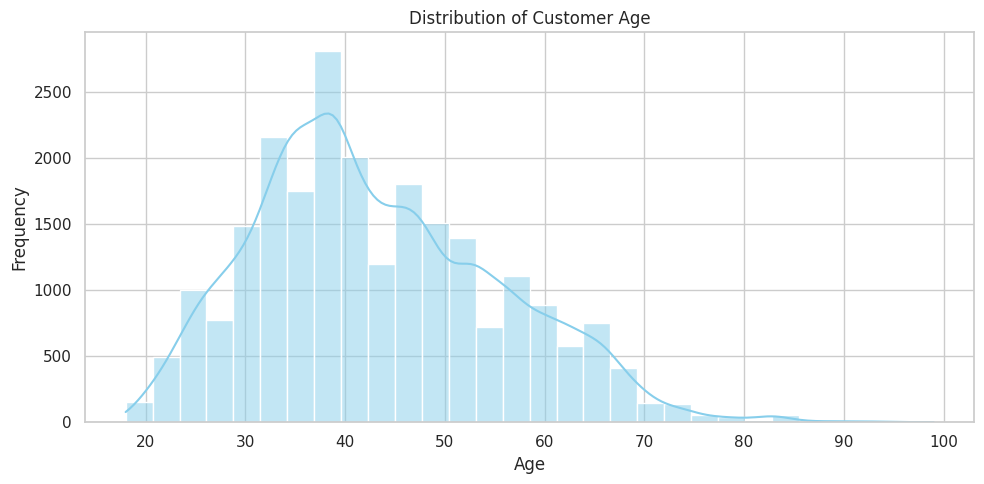

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# Univariate analysis: Age distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

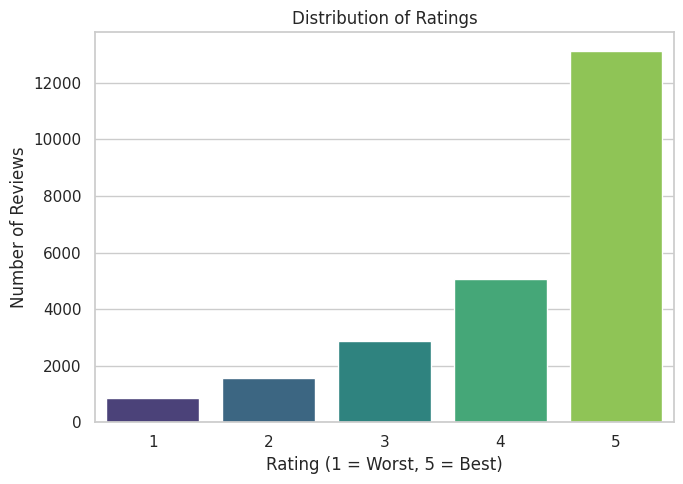

In [24]:


# Rating distribution
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='Rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating (1 = Worst, 5 = Best)')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

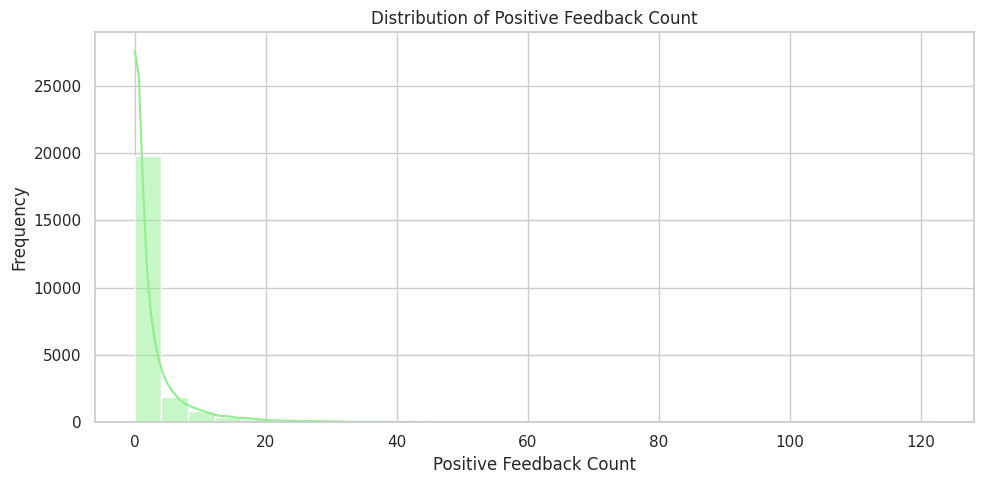

In [25]:


# Positive Feedback Count
plt.figure(figsize=(10, 5))
sns.histplot(df['Positive Feedback Count'], bins=30, color='lightgreen', kde=True)
plt.title('Distribution of Positive Feedback Count')
plt.xlabel('Positive Feedback Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Univariate Analysis — Interpretation
##### 1. Age Distribution
**Range:** Ages span from 18 to 99.

**Peak:** Most customers are between 30–45 years old.

**Interpretation:** The platform appeals primarily to middle-aged women. Young customers (under 25) are fewer.

##### 2. Rating Distribution
**Observation:**

Most ratings are **4 or 5**, suggesting generally high customer satisfaction.

Very few ratings are 1 or 2, indicating fewer negative experiences.

**Interpretation:** The products on this e-commerce platform are mostly well-received. However, due to class imbalance, care must be taken in classification tasks (positive vs. negative reviews).

##### 3. Positive Feedback Count
**Trend:** The vast majority of reviews receive 0–20 positive feedbacks.

**Interpretation:** Most reviews are not heavily interacted with by other users, but a few do get high engagement. We can create a new feature such as a binary Highly Engaged column.

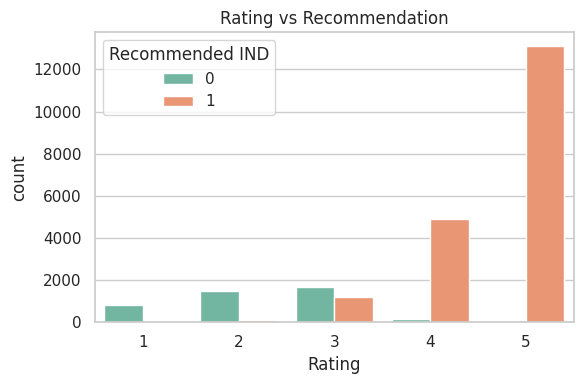

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Rating', hue='Recommended IND', data=df, palette='Set2')
plt.title("Rating vs Recommendation")
plt.tight_layout()
# plt.savefig("/mnt/data/rating_vs_recommend.png")
plt.show()
plt.close()

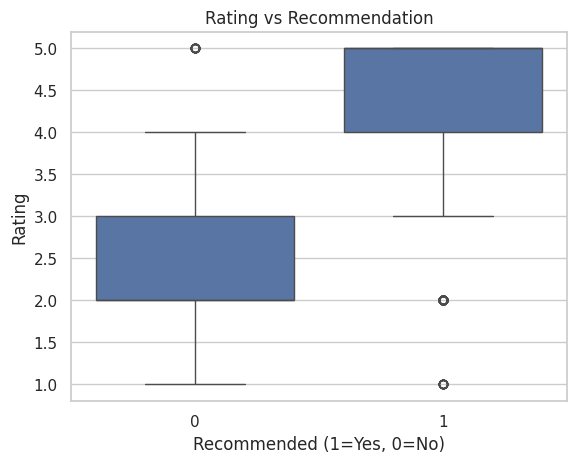

In [34]:
sns.boxplot(x='Recommended IND', y='Rating', data=df)
plt.title('Rating vs Recommendation')
plt.xlabel('Recommended (1=Yes, 0=No)')
plt.ylabel('Rating')
plt.show()


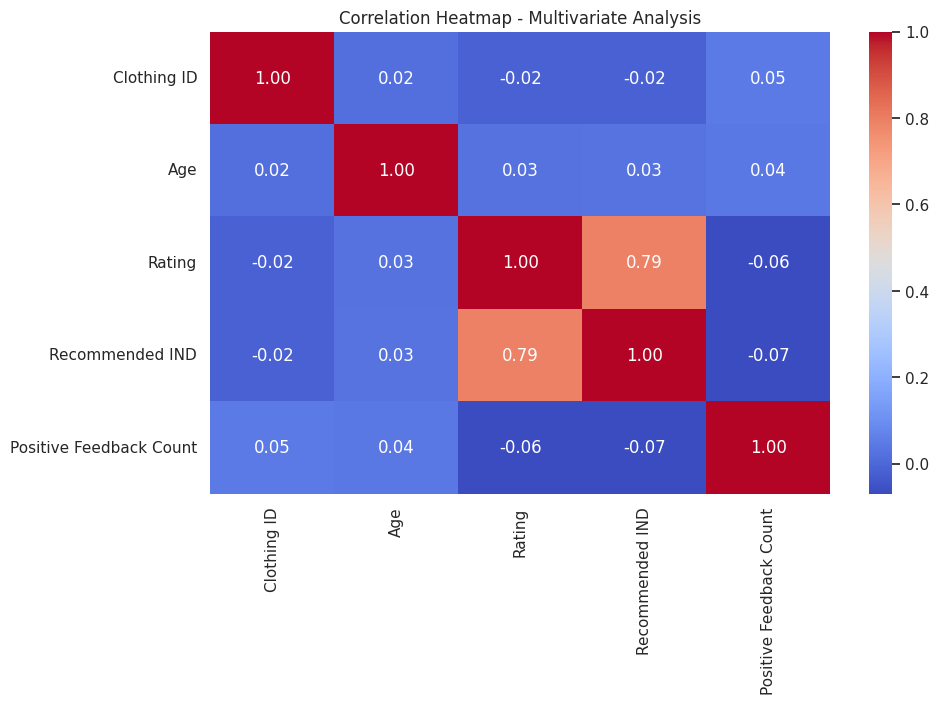

In [35]:
df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True)

# Correlation matrix for numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Multivariate Analysis")
plt.show()

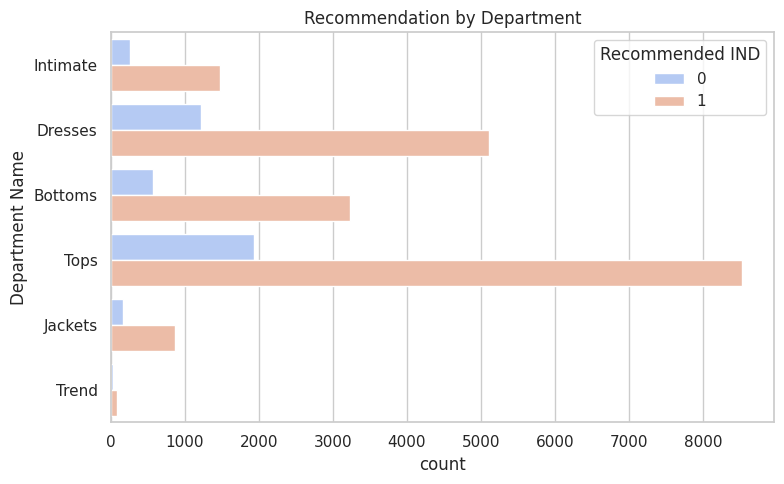

In [31]:
# Bivariate: Department vs Recommendation
plt.figure(figsize=(8, 5))
sns.countplot(y='Department Name', hue='Recommended IND', data=df, palette='coolwarm')
plt.title("Recommendation by Department")
plt.tight_layout()
# plt.savefig("/mnt/data/department_vs_recommend.png")
plt.show()

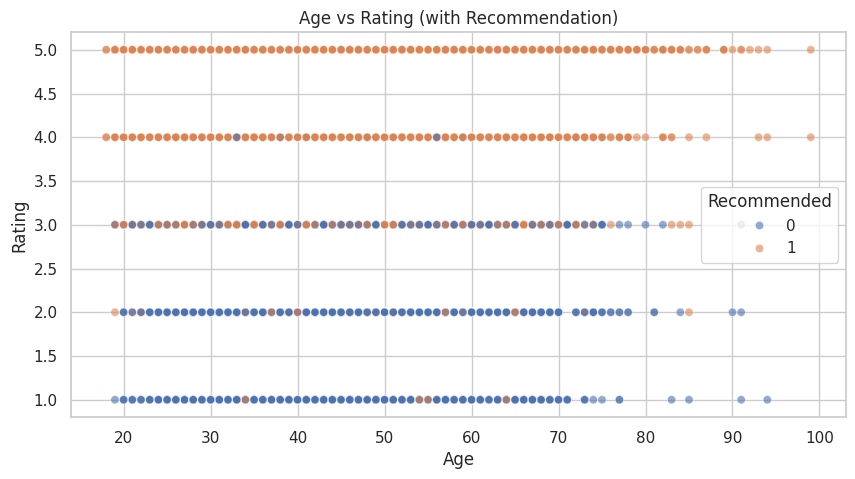

In [32]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Age', y='Rating', hue='Recommended IND', data=df, alpha=0.6)
plt.title('Age vs Rating (with Recommendation)')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.legend(title='Recommended')
plt.show()


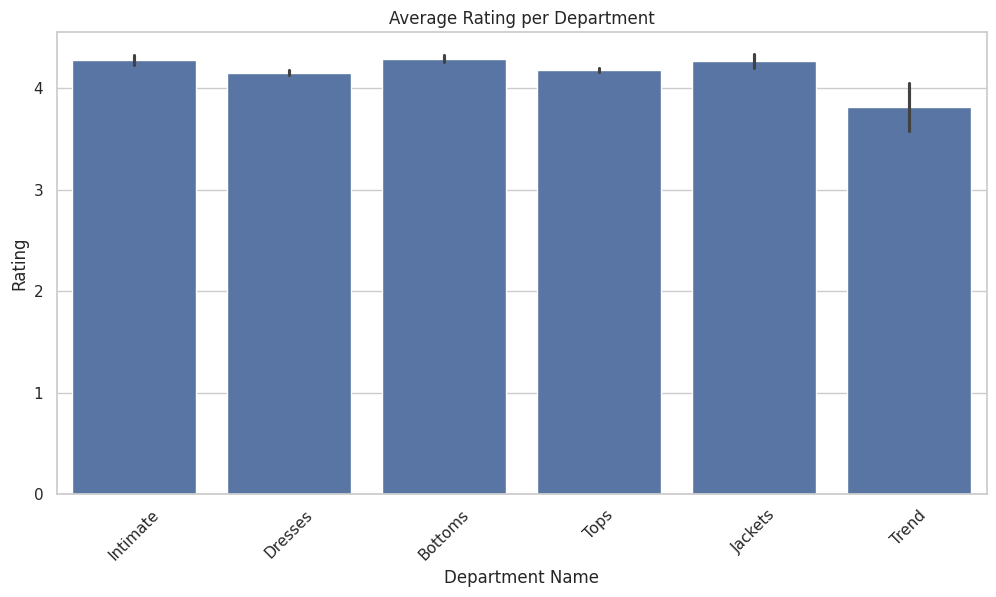

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Department Name', y='Rating', data=df)
plt.title('Average Rating per Department')
plt.xticks(rotation=45)
plt.show()


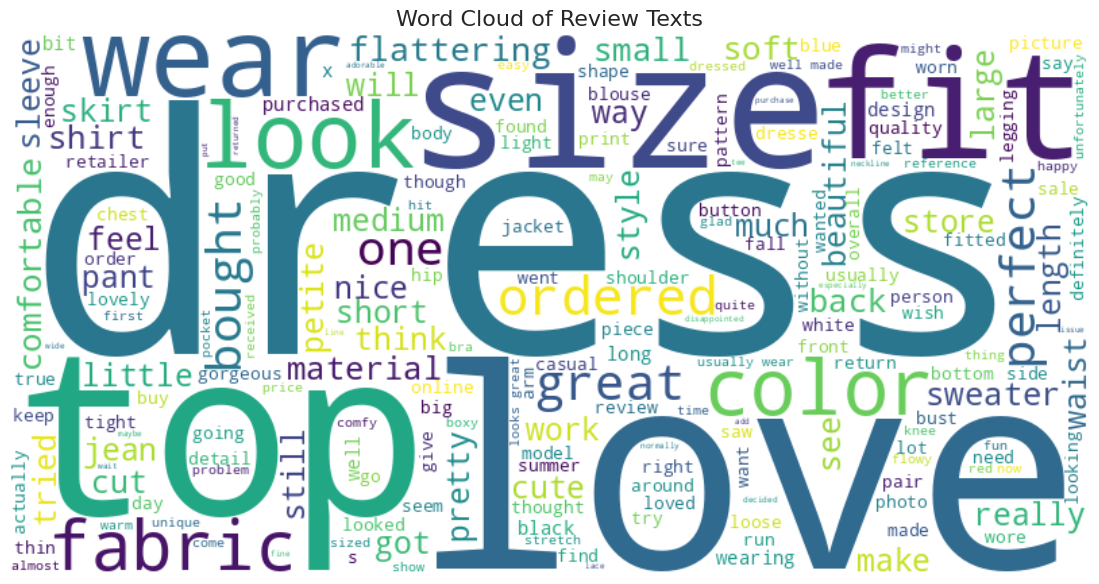

In [26]:
from wordcloud import WordCloud, STOPWORDS

# Combine all review texts (excluding missing ones)
text = " ".join(review for review in df['Review Text'].dropna())

# Define stopwords
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white", colormap="viridis").generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Review Texts", fontsize=16)
plt.tight_layout()
plt.show()
